# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
## **Actividad Individual Semana 9: Pronósticos con Series de Tiempo**


#### **Nombre:** Javier Alejandro Pérez Garza
#### **Matrícula:** A01284386

In [37]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

# **0 - Preparando los datos**

In [38]:
from google.colab import drive
drive.mount('/content/drive')
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4030 - Inteligencia Artificial y Aprendizaje Automatico/Semana 9/"
os.chdir(DIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
import random
import keras
from keras import Sequential
from keras import layers
from keras.layers import LSTM, Dense


import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("monthly_champagne_sales.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [41]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

df.head()

,ds,y
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [43]:
df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
df_temp

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [44]:
print(df.shape)
print(df_temp.shape)

(105, 2)
(105, 1)


In [45]:
df_temp.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq=None)

In [46]:
df_temp.index.freq = 'MS'  # MS-Month-start-frequency

df_temp.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq='MS')

In [47]:
vars = 12

train = df_temp.iloc[0:-vars,:]

test = df_temp.iloc[-vars:,:]

In [48]:
train.shape

(93, 1)

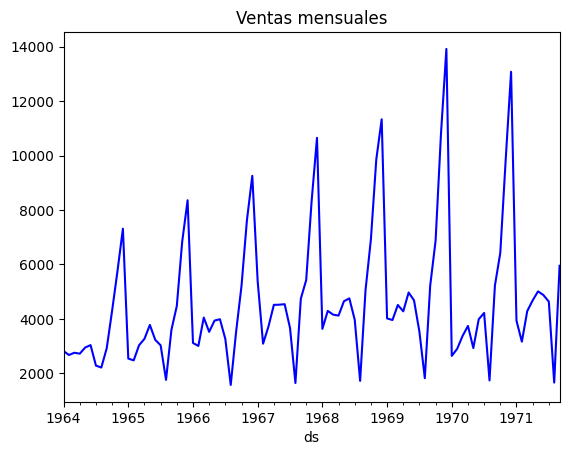

In [49]:
train['y'].plot(title='Ventas mensuales', style='-b')
plt.show()

# **1 - Modelo ingenuo (Baseline / Persistance / Naive model)**

In [50]:
test['y'].values

array([ 6981,  9851, 12670,  4348,  3564,  4577,  4788,  4618,  5312,
        4298,  1413,  5877])

In [51]:
history = [float(x) for x in train['y'].values]   # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
predictions = []   # Lista que contendrá las predicciones del modelo ingenuo.

for i in range(len(test['y'])):
  # Obtenemos las predicciones:
  yhat = float(history[-1])   # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = float(test.iloc[i]['y'])   # Ahora vamos tomando los datos de Test.
  history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
naive_rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % naive_rmse)

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


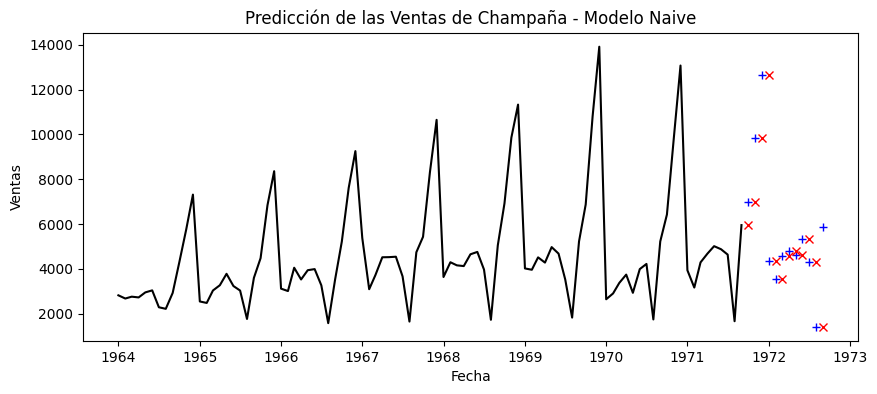

In [52]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.title('Predicción de las Ventas de Champaña - Modelo Naive')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
ax = plt.plot(train['y'], '-k')  # Datos de entrenamiento de 1949 a 1959 (los históricos).
ax = plt.plot(test['y'], '+b')    # Datos de prueba reales del año 1960 (los del útimo año a predecir).
ax = plt.plot(test.index, predictions, 'xr')  # Predicciones del modelo ingenuo para el último año 1960.

# **2 - Modelo ARIMA**

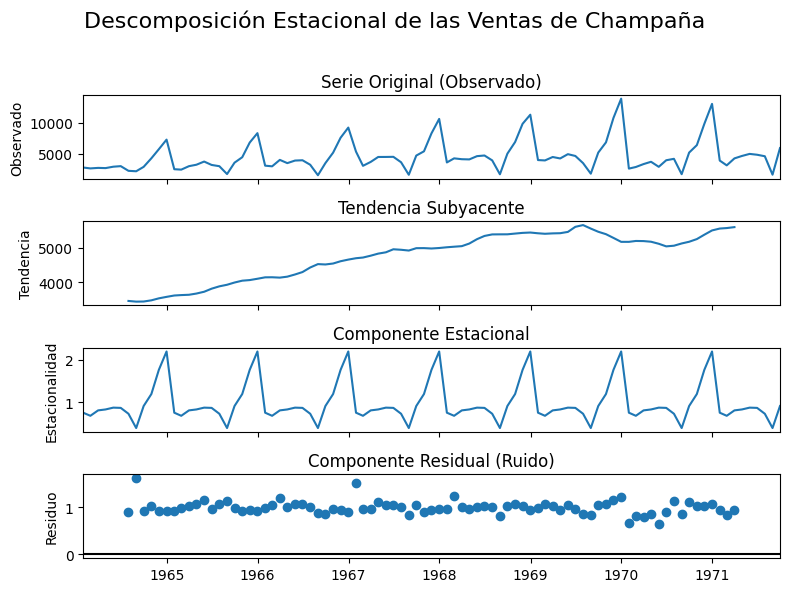

In [53]:
decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='multiplicative')  # <<<---- Observa que el modelo es multiplicativo
fig = decomposition.plot()
fig.set_size_inches(8,6)

# Mejoramos el gráfico con títulos específicos para cada componente
fig.suptitle('Descomposición Estacional de las Ventas de Champaña', fontsize=16)

# Añadimos títulos a cada subgráfico para clarificar su contenido
fig.axes[0].set_ylabel("Observado")
fig.axes[0].set_title("Serie Original (Observado)")

fig.axes[1].set_ylabel("Tendencia")
fig.axes[1].set_title("Tendencia Subyacente")

fig.axes[2].set_ylabel("Estacionalidad")
fig.axes[2].set_title("Componente Estacional")

fig.axes[3].set_ylabel("Residuo")
fig.axes[3].set_title("Componente Residual (Ruido)")

# Mostramos el gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustamos para que el título principal no se sobreponga
plt.show()

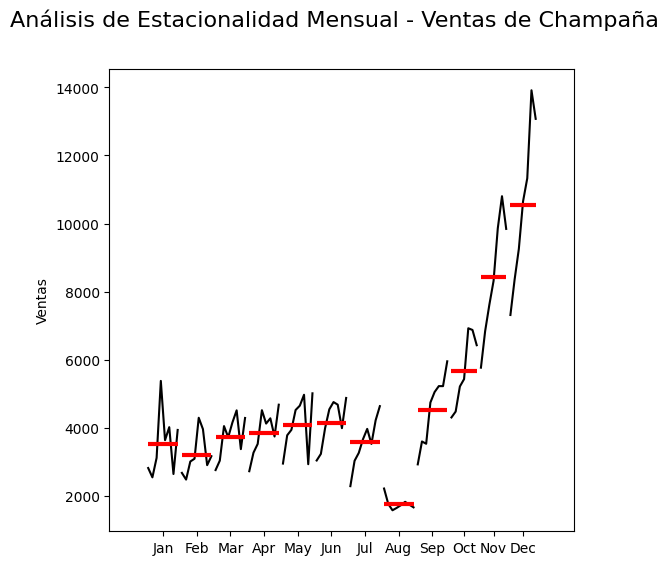

In [54]:
# Gráfica para detección de estacionalidad mensual:
fig = month_plot(train['y'].resample('M').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
fig.suptitle('Análisis de Estacionalidad Mensual - Ventas de Champaña', fontsize=16)
plt.show()

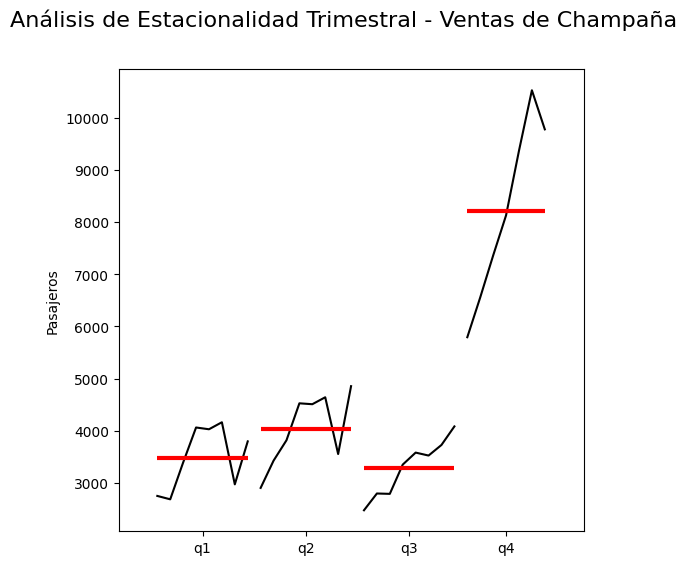

In [55]:
# Si queremos graficar y detectar estacionalidad trimestral:
fig = quarter_plot(train['y'].resample('Q').mean(), ylabel='Pasajeros')
fig.set_size_inches(6,6)
fig.suptitle('Análisis de Estacionalidad Trimestral - Ventas de Champaña', fontsize=16)
plt.show()

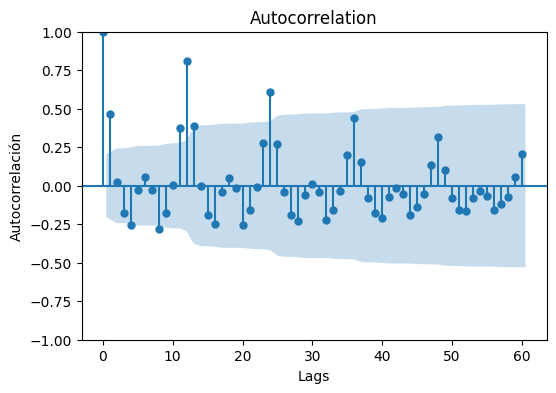

In [56]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['y'], lags=60, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelación')
plt.show()

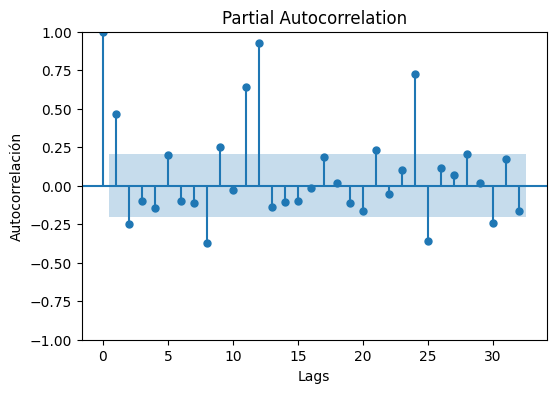

In [57]:
# Gráfico de Autocorrelación Parcial (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['y'], lags = 32, ax = ax, method="ols")
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelación')
plt.show()

In [58]:
def difference(dataset, interval=1):
  diff = []

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)



# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [59]:
# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [float(x) for x in train.loc[:,'y'].values]   # train-ndarray : columna solo con los registros de pasajeros "y".
                               # history-list : lista con los datos del train.

predictions = []   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['y'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)    # diff-list: lista de los datos de diferencias para transformar SARIMA en ARIMA.

  # Generamos el modelo.
  model = ARIMA(diff, order=(2,0,3),)
  model_fit = model.fit(method_kwargs={'maxiter':300})  # Aumentar las iteraciones para evitar el WarningConvergence.

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, float(yhat), months_in_year)    # El "history" sigue siendo la lista de arriba.
                                                              # El nuevo "yhat" es cada un nuevo valor (float) de predicción.
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = float(test.iloc[i]['y'])   #  cada dato es un flotante.
  history.append(obs)   #  history-list : se va incrementado a partir del Train con los registros-observaciones reales.

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
ARIMA_rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % ARIMA_rmse)

>Esperado-real = 6981, Predicción = 6712.498
>Esperado-real = 9851, Predicción = 9945.930
>Esperado-real = 12670, Predicción = 13333.540
>Esperado-real = 4348, Predicción = 4326.492
>Esperado-real = 3564, Predicción = 3545.380
>Esperado-real = 4577, Predicción = 4394.194
>Esperado-real = 4788, Predicción = 4855.009
>Esperado-real = 4618, Predicción = 5391.729
>Esperado-real = 5312, Predicción = 5245.012
>Esperado-real = 4298, Predicción = 4909.811
>Esperado-real = 1413, Predicción = 1579.123
>Esperado-real = 5877, Predicción = 6035.118

Error-Modelo-ARIMA: RMSE: 364.024


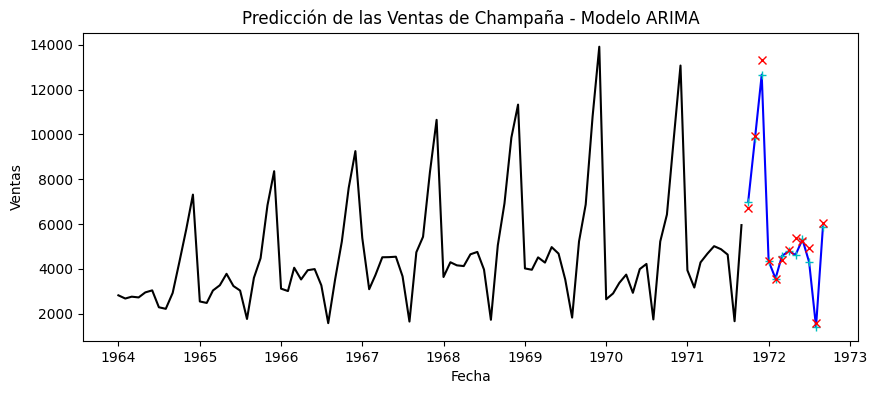

In [60]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.title('Predicción de las Ventas de Champaña - Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '-b')
ax = plt.plot(test['y'], '+c')
ax = plt.plot(test.index, predictions, 'xr')

# **3 - Modelo Facebook-Meta-Prophet**

In [61]:
train = df.iloc[0:-vars, :]
test = df.iloc[-vars:, :]

In [62]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                seasonality_prior_scale=0.08)     # Controla la flexibilidad de la componente Trend, mayor valor mayores fluctuaciones.
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxrvhf_qm/wgan8mws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxrvhf_qm/kqwqf6vr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89303', 'data', 'file=/tmp/tmpxrvhf_qm/wgan8mws.json', 'init=/tmp/tmpxrvhf_qm/kqwqf6vr.json', 'output', 'file=/tmp/tmpxrvhf_qm/prophet_modelp7najcwt/prophet_model-20250310150222.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:02:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:02:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [63]:
pred_FP = model.predict(test)['yhat']
FP_rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % FP_rmse)


Error-Modelo-FacebookProphet: RMSE: 397.963


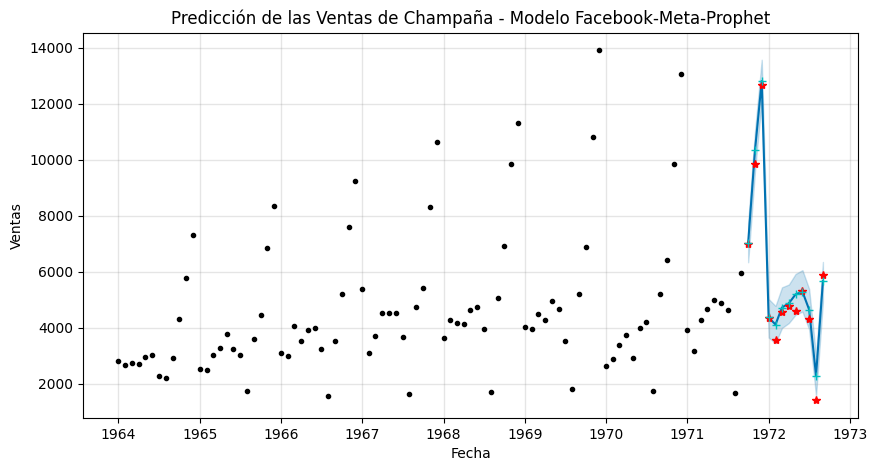

In [64]:
forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)               # Las predicciones se muestran con la línea continua, junto con su región de variabilidad de la predicción.
plt.title('Predicción de las Ventas de Champaña - Modelo Facebook-Meta-Prophet')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test) con puntos rojos, para observar la diferencia.
ax = plt.plot(test['ds'], forecast['yhat'], '+c')    # Valores reales.

# **4 - Long Short Term Memory (LSTM)**

In [65]:
# Escalado de Datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_temp_scaled = df_temp.copy()
df_temp_scaled['y'] = scaler.fit_transform(df_temp[['y']])

# División en conjunto de entrenamiento y prueba (últimos 20 días para prueba)
train = df_temp_scaled.iloc[0:-20]  # Todas las filas excepto las últimas 20 para entrenamiento
test = df_temp_scaled.iloc[-20:]    # Últimas 20 filas para prueba

In [66]:
def creamos_secuencias(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Ventana en este ejercicio de 12 meses de manera continua
        y.append(data[i])  # y el siguiente mes a predecir, dados los 12 anteriores.
    return np.array(X), np.array(y)

In [67]:
window_size = 12

# Creamos las secuencias de entrenamiento
X, y = creamos_secuencias(df[['y']].values, window_size)

print(X.shape)

(93, 12, 1)


In [68]:
# Dividimos los datos en Entrenamiento y Prueba:
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape)   # (secuencias, tamaño_secuencia, variables)
print(X_test.shape)

(79, 12, 1)
(14, 12, 1)


In [69]:
# Agregamos semilla
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#Construimos un modelo secuencial basado en LSTMs:
model = Sequential()
model.add(LSTM(32,  # total de neuronas de la capa LSTM
               return_sequences=True, # para que siga manteniendo el formato de 3 dimensiones.
               activation='relu',
               recurrent_activation='sigmoid',
               ))  # Capa LSTM
model.add(LSTM(16, return_sequences=False, activation='relu'))
model.add(Dense(1))  # Capa de salida

# Compilamos el modelo
model.compile('adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()],   #  despliega RMSE
              )

# y llevamos a cabo el entrenamiento con los cunjuntos de entrenamiento y prueba:
history = model.fit(X_train, y_train, epochs=1100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/1100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - loss: 27033980.0000 - root_mean_squared_error: 5191.4263 - val_loss: 27830446.0000 - val_root_mean_squared_error: 5275.4570
Epoch 2/1100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 22757428.0000 - root_mean_squared_error: 4762.4932 - val_loss: 26780562.0000 - val_root_mean_squared_error: 5174.9941
Epoch 3/1100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 19314100.0000 - root_mean_squared_error: 4386.4336 - val_loss: 25825780.0000 - val_root_mean_squared_error: 5081.9072
Epoch 4/1100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18374474.0000 - root_mean_squared_error: 4276.2036 - val_loss: 25944078.0000 - val_root_mean_squared_error: 5093.5327
Epoch 5/1100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17625734.0000 - root_mean_squared_error: 4187.4307 - val_loss: 25597152.0000 - val_root_mean_squared_error: 5059.3628
Epoch 6/1100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18309994.0000 - root_mean_squared_error: 4272.8135 - va

In [70]:
pred_LSTM = model.predict(X_test[-window_size:])
y_test_real = y_test[-window_size:].reshape(-1, 1)

# Calculamos el RMSE en la escala original de los datos:
LSTM_rmse = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % LSTM_rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step

Error-Modelo-FacebookProphet: RMSE: 681.530


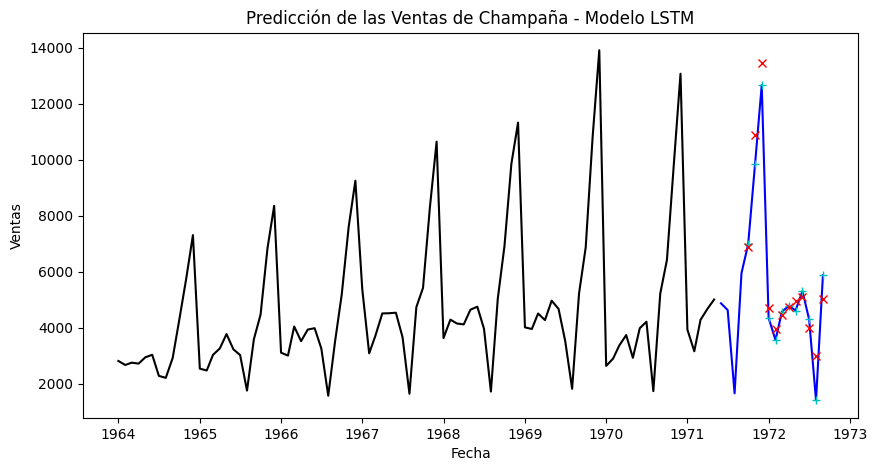

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Predicción de las Ventas de Champaña - Modelo LSTM')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
ax = plt.plot(df['ds'][0:int(0.85 * len(df))], df['y'][0:int(0.85 * len(df))], '-k')  # Datos de entrenamiento
ax = plt.plot(df['ds'][int(0.85 * len(df)):], df['y'][int(0.85 * len(df)):], '-b')    # Datos de prueba dependiendo del tamaño de Test.
ax = plt.plot(df['ds'][-window_size:], df['y'][-window_size:], '+c')    # Datos de prueba incluyendo solo los puntuales reales
ax = plt.plot(df['ds'][-window_size:], pred_LSTM, 'xr')  # Predicciones puntuales del modelo

# **5 - RMSE de modelos**

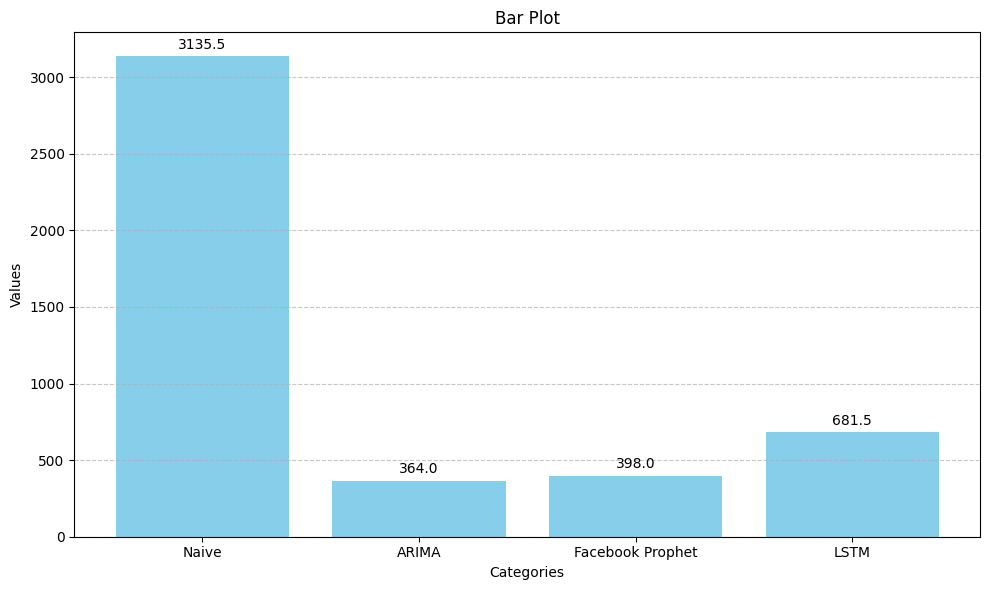

In [72]:
RMSA = [naive_rmse, ARIMA_rmse, FP_rmse, LSTM_rmse]

labels = ['Naive', 'ARIMA', 'Facebook Prophet', 'LSTM']


plt.figure(figsize=(10, 6))
x_pos = np.arange(len(RMSA))

bars = plt.bar(x_pos, RMSA, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(RMSA),
            f'{height:.1f}', ha='center', va='bottom')


plt.title('Bar Plot')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.xticks(x_pos, labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **6 - Conclusiones**

En este análisis, se evaluaron cuatro modelos de predicción de series temporales: Naive, ARIMA, Facebook Prophet y LSTM, aplicados a una serie de tiempo de ventas de champaña y se comparó su desempeño en función del Error Cuadrático Medio (RMSE) para determinar la precisión de cada modelo. De esta manera, a través del estudio de la estacionalidad de los datos y la optimización de hiperparametros se buscaron los mejores ajustes para cada modelo.

**Modelo Naive**

El modelo Naive, que simplemente proyecta el último valor observado como predicción futura, mostró el mayor error de predicción. Esto confirma que, aunque puede ser útil como una referencia base, no es adecuado para capturar patrones estacionales ni tendencias en los datos.

**Modelo ARIMA**

El modelo ARIMA es el modelo que obtuvo el mejor desempeño en términos de RMSE de los cuatro estudiados. Capturó de manera efectiva los patrones de la serie temporal, adaptándose bien a las fluctuaciones y estacionalidad. En este caso, la serie de ventas muestra picos recurrentes en fechas específicas, lo que favorece el uso de un modelo que pueda identificar y extrapolar dichos patrones. Sin embargo, ARIMA puede tener dificultades cuando los datos contienen variaciones abruptas o eventos fuera de lo común, ya que su enfoque se basa en la dependencia lineal de valores pasados. Aún así, su bajo RMSE indica que es un modelo adecuado para este set de datos.

**Facebook Prophet**

Prophet mostró un desempeño similar al ARIMA, aunque ligeramente inferior. Este modelo es particularmente útil en series con patrones estacionales bien definidos, pero en este caso, a pesar de que la serie de ventas de champaña muestra una estacionalidad clara, también tiene fluctuaciones abruptas en ciertos periodos, lo que puede haber afectado la precisión del modelo causando que su precisión fue menor que la de ARIMA.

**Long Short Term Memory (LSTM)**

El modelo LSTM mostró un error alto en comparación con ARIMA y Facebook Prophet. Este modelo tiene potencial para capturar patrones complejos y su desempeño depende en gran medida de la cantidad y calidad de datos. Uno de los principales desafíos al utilizar LSTM para series temporales radica en que la volatilidad en su rendimiento sugiere que pequeños cambios en los ajustes del modelo o su arquitectura pueden influir drásticamente en la calidad de las predicciones.

A pesar de su bajo desempeño en esta actividad, LSTM sigue siendo una opción poderosa cuando se trata de capturar relaciones complejas en series temporales. Sin embargo, su implementación requiere un ajuste cuidadoso para evitar errores elevados y resultados inconsistentes.



## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**